# Prototypical networks for few-shot cell type annotations

This notebook is a part of the ISMB tutorial [Meta-learning for bridging labeled and unlabeled data in biomedicine](http://snap.stanford.edu/metalearning-ismb/).

In this notebook, we wil use [Prototypical networks](https://arxiv.org/abs/1703.05175) to learn cell type annotations from only few-labeled as examples. We will use meta-learning approach to learn across different tissues and then generalize to a new, yet unseen tissues given only few labels. 

## Loading Tabula Muris dataset

We will use [Tabula Muris](https://www.nature.com/articles/s41586-020-2496-1) mouse cell atlas single-cell data. This dataset can be downloaded at [http://snap.stanford.edu/mars/data/tms-facs-mars.tar.gz](http://snap.stanford.edu/mars/data/tms-facs-mars.tar.gz). 

In [5]:
import scanpy.api as sc
import numpy as np

In [9]:
# set the path to the data
dataset_root = '../tabula-muris-senis-facs_mars.h5ad'

In [14]:
def load_sc_data(root):
    """Preprocess single cell data"""
    sc_data = sc.read_h5ad(dataset_root)
    sc_data = sc_data[sc_data.obs['age']=='3m'] # reduce file size by taking only 3months old mouse to be able to locally run the example
    sc.pp.filter_cells(sc_data, min_counts=5000)
    sc.pp.filter_cells(sc_data, min_genes=500)
        
    sc.pp.normalize_per_cell(sc_data, counts_per_cell_after=1e4) 
    sc_data = sc.pp.filter_genes_dispersion(sc_data, subset = False, min_disp=.5, max_disp=None, 
                                  min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None, 
                                  log=True, copy=True)
    sc_data = sc_data[:,sc_data.var.highly_variable]
    sc.pp.log1p(sc_data)
    sc.pp.scale(sc_data, max_value=10, zero_center=True)
    sc_data.X[np.isnan(sc_data.X)] = 0
    
    return sc_data

In [15]:
tm_data = load_sc_data(dataset_root)

Trying to set attribute `.obs` of view, making a copy.


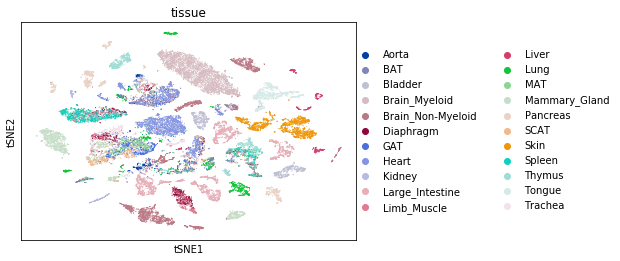

In [676]:
sc.pp.pca(tm_data)
sc.tl.tsne(tm_data)
sc.pl.tsne(tm_data, color = 'tissue')

## Setting model and training parameters

In [16]:
from __future__ import print_function
import numpy as np
import torch
import os
import pandas as pd
import warnings
from tqdm import tqdm

import torch.utils.data as data
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.modules import Module

warnings.filterwarnings('ignore')

In [17]:
# Setting model parameters
dataset_root = '/Users/maria/Desktop/tabula-muris-senis-facs_mars.h5ad'
epochs= 100
iterations = 100
learning_rate = 0.001
lr_scheduler_step = 20
lr_scheduler_gamma = 0.5
classes_per_it_tr = 5 # number of classes to sample at each iteration
classes_per_it_val = 5
num_support_tr = 1 # support set size during training
num_query_tr = 1 # query set size
num_support_val = 1 # support set size during evaluation
num_query_val = 1
manual_seed = 25

In [18]:
np.random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.cuda.manual_seed(manual_seed)

In [19]:
# choosing cross-tisue split for training validation and test set
data_split = {'train': ['Heart','Aorta','Kidney'],
             'val':['Lung'],
             'test':['Liver']}

## Data loaders 

In [20]:
class CellDataset(data.Dataset):
    """Examples and labels for single cell dataset"""
    
    def __init__(self, adata, mode, min_samples=20):
        
        super(CellDataset, self).__init__()
        
        selected_tissues = set(data_split[mode])
        adata = adata[adata.obs['tissue'].isin(selected_tissues)]
        
        # filter cell types with less than min_samples cells
        filtered_index = adata.obs.groupby(["cell_ontology_class_reannotated"]) \
                        .filter(lambda group: len(group) >= min_samples) \
                        .reset_index()['index']
        adata = adata[filtered_index]
    
        # convert label to torch tensor y
        targets = adata.obs['cell_ontology_class_reannotated'].cat.codes
        adata.obs['label'] = targets

        self.x = adata.X
        self.y = adata.obs['label']

        print("*** Dataset: Found %d items " % self.x.shape[0])
        print("*** Dataset: Found %d classes" % len(np.unique(self.y)))

        shape = 1, self.x.shape[1]
        shape = self.x.shape[1]
        self.x = [torch.from_numpy(inst).view(shape) for inst in self.x]
        self.y = tuple(self.y.tolist())


    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.nitems

    def get_dim(self):
        return self.x[0].shape[0]

In [21]:
class PrototypicalBatchSampler(object):
    """Yield a batch of indexes at each iteration. At every iteration the batch indexes corresponds to  'num_support' + 'num_query' samples
    for 'classes_per_it' random classes."""

    def __init__(self, labels, classes_per_it, num_samples, iterations):
        super(PrototypicalBatchSampler, self).__init__()
        self.labels = labels
        self.classes_per_it = classes_per_it
        self.sample_per_class = num_samples
        self.iterations = iterations

        self.classes, self.counts = np.unique(self.labels, return_counts=True)
        self.classes = torch.LongTensor(self.classes)

        # create a matrix, indexes, of dim: classes X max(elements per class)
        # fill it with nans
        # for every class c, fill the relative row with the indices samples belonging to c
        # in numel_per_class we store the number of samples for each class/row
        self.idxs = range(len(self.labels))
        print('Number of examples per class: ')
        print(self.counts)
        self.indexes = np.empty((len(self.classes), max(self.counts)), dtype=int) * np.nan
        self.indexes = torch.Tensor(self.indexes)
        self.numel_per_class = torch.zeros_like(self.classes)
        for idx, label in enumerate(self.labels):
            label_idx = np.argwhere(self.classes == label).item()
            self.indexes[label_idx, np.where(np.isnan(self.indexes[label_idx]))[0][0]] = idx
            self.numel_per_class[label_idx] += 1

    def __iter__(self):
        spc = self.sample_per_class
        cpi = self.classes_per_it
        
        for it in range(self.iterations):
            batch_size = spc * cpi
            batch = torch.LongTensor(batch_size)
            c_idxs = torch.randperm(len(self.classes))[:cpi]
            
            for i, c in enumerate(self.classes[c_idxs]):
                s = slice(i * spc, (i + 1) * spc)
                label_idx = torch.arange(len(self.classes)).long()[self.classes == c].item()
                sample_idxs = torch.randperm(self.numel_per_class[label_idx])[:spc] 
                batch[s] = self.indexes[label_idx][sample_idxs] # error when a class does not have spc examples
            batch = batch[torch.randperm(len(batch))]
            
            yield batch

    def __len__(self):
        return self.iterations

In [22]:
def init_sampler(labels, mode):
    if mode=='train':
        classes_per_it = classes_per_it_tr
        num_samples = num_support_tr + num_query_tr
    else:
        classes_per_it = classes_per_it_val
        num_samples = num_support_val + num_query_val

    return PrototypicalBatchSampler(labels, classes_per_it, num_samples, iterations)

In [25]:
def init_dataloader(dataset, mode):
    """Initializing data loaders for train, val or test mode."""
    
    dataset = CellDataset(dataset, mode)
    sampler = init_sampler(dataset.y, mode)
    
    n_classes = len(np.unique(dataset.y))
    if mode=='train' and n_classes < classes_per_it_tr:
        raise(Exception('There are not enough classes in the dataset to satisfy the chosen classes_per_it. Decrease the classes_per_it_tr option.'))
    if (mode=='val' or mode=='test') and n_classes < classes_per_it_val:
        raise(Exception('There are not enough classes in the dataset to satisfy the chosen classes_per_it. Decrease the classes_per_it_val option.'))
    dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)
    
    return dataloader

## Model definition

For model we will use simple 2-layer fully connected neural network.

In [26]:
def full_block(in_features, out_features, p_drop):
    return nn.Sequential(
        nn.Linear(in_features, out_features, bias=True),
        nn.ReLU(),
        nn.Dropout(p=p_drop),
    )

In [27]:
class ProtoNet(nn.Module):
    
    def __init__(self, x_dim, hid_dim=64, z_dim=64, p_drop=0.2):
        super(ProtoNet, self).__init__()
        self.encoder = nn.Sequential(
            full_block(x_dim, hid_dim, p_drop),
            full_block(hid_dim, z_dim, p_drop),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

## Loss definition

In [28]:
def euclidean_dist(x, y):
    """Compute euclidean distance between two tensors."""
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

In [29]:
def get_idxs(n_support, target):
    """Get indexes of support and query sets."""
    
    classes = torch.unique(target)
    support_idxs = list(map(lambda c: target.eq(c).nonzero()[:n_support].squeeze(1), classes))
    l = list(map(lambda c: target.eq(c).nonzero()[n_support:], classes))
    query_idxs = torch.cat(list(map(lambda c: target.eq(c).nonzero()[n_support:], classes)))
    query_idxs  = query_idxs.view(-1)
    
    return support_idxs, query_idxs

In [30]:
def prototypical_loss(input1, target, n_support):
    
    support_idxs, query_idxs = get_idxs(n_support, target)
    prototypes = torch.stack([input1[idx_class].mean(0) for idx_class in support_idxs])

    query_samples = input1[query_idxs]
    dists = euclidean_dist(query_samples, prototypes)
    log_p_y = F.log_softmax(-dists, dim=1)
    
    target = target[query_idxs]
    uniq, counts = np.unique(target.numpy(), return_counts=True)
    uniq_counts = dict(zip(uniq, counts))
    uniq_app_order = pd.unique(target.numpy())
    target_inds = torch.Tensor()
    
    for idx, class_id in enumerate(uniq_app_order):
        target_inds = torch.cat((target_inds, torch.Tensor([idx]).repeat(uniq_counts[class_id])))
    target_inds = target_inds.long()
    
    loss = torch.nn.NLLLoss()
    loss_val = loss(log_p_y, target_inds)
     
    _, y_hat = log_p_y.max(1)
    acc_val = y_hat.eq(target_inds.squeeze()).float().mean()
    
    return loss_val,  acc_val

In [31]:
class PrototypicalLoss(Module):
    """Loss class."""
    
    def __init__(self, n_support):
        super(PrototypicalLoss, self).__init__()
        self.n_support = n_support

    def forward(self, input, target):
        return prototypical_loss(input, target, self.n_support)

## Model training and testing

Defining functions to train and test the model.

In [33]:
def train(tr_dataloader, val_dataloader, model, optim, lr_scheduler):
    '''
    Train the model with the prototypical learning algorithm
    '''

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    best_acc = 0

    for epoch in range(epochs): # outer loop over epochs
        print('*** Epoch: {} ***'.format(epoch))
        tr_iter = iter(tr_dataloader)
        
        model.train() # model training
        
        for batch in tqdm(tr_iter): # inner loop over episodes
            optim.zero_grad()
            
            x, y = batch
            model_output = model(x) 
            loss, acc = prototypical_loss(model_output, y, num_support_tr)
            loss.backward()
            optim.step()
            
            train_loss.append(loss.item())
            train_acc.append(acc.item())
        avg_loss = np.mean(train_loss[-iterations:])
        avg_acc = np.mean(train_acc[-iterations:])
        print('Avg train loss: {}, Avg train acc: {}'.format(avg_loss, avg_acc))
        lr_scheduler.step()
       
        val_iter = iter(val_dataloader)
        
        model.eval() # model evaluation
        for batch in tqdm(val_iter):
            x, y = batch
            model_output = model(x) 
            loss, acc = prototypical_loss(model_output, y, num_support_val)
            val_loss.append(loss.item())
            val_acc.append(acc.item())
        avg_loss = np.mean(val_loss[-iterations:])
        avg_acc = np.mean(val_acc[-iterations:])
        info = ' (Best)' if avg_acc >= best_acc else ' (Best: {})'.format(best_acc)
        print('Avg val loss: {}, Avg val acc: {}{}'.format(avg_loss, avg_acc, info))
        if avg_acc >= best_acc:
            best_acc = avg_acc
            best_state = model.state_dict()
            
    return best_state

In [34]:
def test(test_dataloader, model):
    avg_acc = list()
    epoch = iter(test_dataloader)
    for batch in epoch:
        x, y = batch
        model_output = model(x)
        _, acc = prototypical_loss(model_output, y, num_support_val)
        avg_acc.append(acc.item())
    avg_acc = np.mean(avg_acc)
    print('Test accuracy: {}'.format(avg_acc))

    return avg_acc

## Train and test the model on the Tabula Muris data

In [35]:
# main
tr_dataloader = init_dataloader(tm_data, 'train')
val_dataloader = init_dataloader(tm_data, 'val')
test_dataloader = init_dataloader(tm_data, 'test')

Trying to set attribute `.obs` of view, making a copy.


*** Dataset: Found 5577 items 
*** Dataset: Found 21 classes
Number of examples per class: 
[  21   46  189  159  164 1179   46  113 2184   25  124   55   75   69
   32  490  281   56   65  158   46]


Trying to set attribute `.obs` of view, making a copy.


*** Dataset: Found 1675 items 
*** Dataset: Found 17 classes
Number of examples per class: 
[ 55  36  27 140 420  21  68  51 129  52 362  29  56  39  55  96  39]


Trying to set attribute `.obs` of view, making a copy.


*** Dataset: Found 702 items 
*** Dataset: Found 5 classes
Number of examples per class: 
[ 34  47 189 401  31]


In [36]:
model = ProtoNet(tr_dataloader.dataset.get_dim())
optim = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                               gamma=lr_scheduler_gamma,
                                               step_size=lr_scheduler_step)

In [37]:
best_state = train(tr_dataloader, val_dataloader, model, optim, lr_scheduler)

 21%|██        | 21/100 [00:00<00:00, 209.03it/s]

*** Epoch: 0 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 2.553865002281964, Avg train acc: 0.5260000130534173
Avg val loss: 0.8296412026882172, Avg val acc: 0.7480000120401382 (Best)
*** Epoch: 1 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 2.260040717124939, Avg train acc: 0.5500000135600567
Avg val loss: 0.7599664797633886, Avg val acc: 0.7880000093579292 (Best)
*** Epoch: 2 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 1.8112909696996211, Avg train acc: 0.5880000127851963
Avg val loss: 0.8208539626002311, Avg val acc: 0.7400000111758709 (Best: 0.7880000093579292)
*** Epoch: 3 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 1.721999194920063, Avg train acc: 0.5500000125169754
Avg val loss: 0.8709484413266182, Avg val acc: 0.7420000126957893 (Best: 0.7880000093579292)
*** Epoch: 4 ***


 47%|████▋     | 47/100 [00:00<00:00, 467.09it/s]

Avg train loss: 1.3030479819327594, Avg train acc: 0.620000012665987


 23%|██▎       | 23/100 [00:00<00:00, 224.30it/s]

Avg val loss: 0.9085372784733772, Avg val acc: 0.7220000131428241 (Best: 0.7880000093579292)
*** Epoch: 5 ***


100%|██████████| 100/100 [00:00<00:00, 497.55it/s]

Avg train loss: 1.1369265178591013, Avg train acc: 0.6340000143647194



 24%|██▍       | 24/100 [00:00<00:00, 236.65it/s]

Avg val loss: 0.7841975075006485, Avg val acc: 0.7620000122487545 (Best: 0.7880000093579292)
*** Epoch: 6 ***


 45%|████▌     | 45/100 [00:00<00:00, 443.39it/s]

Avg train loss: 1.112502623796463, Avg train acc: 0.680000012665987


 24%|██▍       | 24/100 [00:00<00:00, 232.23it/s]

Avg val loss: 0.7751751153171063, Avg val acc: 0.7280000121891499 (Best: 0.7880000093579292)
*** Epoch: 7 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 1.0984658966213465, Avg train acc: 0.6560000137984753
Avg val loss: 0.8848359972238541, Avg val acc: 0.7460000117123127 (Best: 0.7880000093579292)
*** Epoch: 8 ***


 51%|█████     | 51/100 [00:00<00:00, 509.22it/s]

Avg train loss: 0.928821200095117, Avg train acc: 0.6980000123381614


 22%|██▏       | 22/100 [00:00<00:00, 212.92it/s]

Avg val loss: 0.8132052147388458, Avg val acc: 0.7700000123679638 (Best: 0.7880000093579292)
*** Epoch: 9 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.9447881443053484, Avg train acc: 0.6820000129938125
Avg val loss: 0.8454599678516388, Avg val acc: 0.7560000121593475 (Best: 0.7880000093579292)
*** Epoch: 10 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.9844968279451132, Avg train acc: 0.646000012010336
Avg val loss: 0.8184999620914459, Avg val acc: 0.7460000135004521 (Best: 0.7880000093579292)
*** Epoch: 11 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.8926738336402923, Avg train acc: 0.6900000131130218
Avg val loss: 0.8373646324872971, Avg val acc: 0.7520000123977661 (Best: 0.7880000093579292)
*** Epoch: 12 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.8239117028191686, Avg train acc: 0.6920000129938125
Avg val loss: 0.7690557214617729, Avg val acc: 0.7420000125467777 (Best: 0.7880000093579292)
*** Epoch: 13 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.925271926894784, Avg train acc: 0.6760000123083592
Avg val loss: 0.7900237514078617, Avg val acc: 0.7480000120401382 (Best: 0.7880000093579292)
*** Epoch: 14 ***


 48%|████▊     | 48/100 [00:00<00:00, 475.70it/s]

Avg train loss: 0.7501578873582184, Avg train acc: 0.720000011920929


 23%|██▎       | 23/100 [00:00<00:00, 225.34it/s]

Avg val loss: 0.8355092552304267, Avg val acc: 0.7160000135004521 (Best: 0.7880000093579292)
*** Epoch: 15 ***


 53%|█████▎    | 53/100 [00:00<00:00, 524.70it/s]

Avg train loss: 0.8215561070106924, Avg train acc: 0.6980000123381614


 22%|██▏       | 22/100 [00:00<00:00, 215.14it/s]

Avg val loss: 0.8718087542057037, Avg val acc: 0.712000012844801 (Best: 0.7880000093579292)
*** Epoch: 16 ***


 47%|████▋     | 47/100 [00:00<00:00, 468.25it/s]

Avg train loss: 0.7547719859704375, Avg train acc: 0.7000000110268593


 24%|██▍       | 24/100 [00:00<00:00, 239.85it/s]

Avg val loss: 0.8364762867987156, Avg val acc: 0.7500000122189522 (Best: 0.7880000093579292)
*** Epoch: 17 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.8070138598978519, Avg train acc: 0.7040000125765801
Avg val loss: 0.9251801392436028, Avg val acc: 0.7080000135302543 (Best: 0.7880000093579292)
*** Epoch: 18 ***


 91%|█████████ | 91/100 [00:00<00:00, 452.52it/s]

Avg train loss: 0.7420097182318568, Avg train acc: 0.7260000117123127


 24%|██▍       | 24/100 [00:00<00:00, 239.73it/s]

Avg val loss: 0.7985076916217804, Avg val acc: 0.7360000124573708 (Best: 0.7880000093579292)
*** Epoch: 19 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.7736520032864064, Avg train acc: 0.7160000136494636
Avg val loss: 0.7235943013429642, Avg val acc: 0.7940000113844872 (Best)
*** Epoch: 20 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.7409770528227091, Avg train acc: 0.7240000109374524
Avg val loss: 0.8168083891272545, Avg val acc: 0.7220000123977661 (Best: 0.7940000113844872)
*** Epoch: 21 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.8202000536769628, Avg train acc: 0.7120000123977661
Avg val loss: 0.7069255965948105, Avg val acc: 0.8040000101923943 (Best)
*** Epoch: 22 ***


 46%|████▌     | 46/100 [00:00<00:00, 455.67it/s]

Avg train loss: 0.8792866533249617, Avg train acc: 0.7660000106692314


 23%|██▎       | 23/100 [00:00<00:00, 229.40it/s]

Avg val loss: 0.7843543419241905, Avg val acc: 0.7240000127255917 (Best: 0.8040000101923943)
*** Epoch: 23 ***


 45%|████▌     | 45/100 [00:00<00:00, 447.69it/s]

Avg train loss: 0.6889799556136131, Avg train acc: 0.7500000116229057


 22%|██▏       | 22/100 [00:00<00:00, 216.65it/s]

Avg val loss: 0.7630112755298615, Avg val acc: 0.7620000126957893 (Best: 0.8040000101923943)
*** Epoch: 24 ***


100%|██████████| 100/100 [00:00<00:00, 505.99it/s]


Avg train loss: 0.5698186597041786, Avg train acc: 0.7640000116825104
Avg val loss: 0.7129627420008182, Avg val acc: 0.7580000102519989 (Best: 0.8040000101923943)
*** Epoch: 25 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.6305836074659601, Avg train acc: 0.760000010728836
Avg val loss: 0.782883853316307, Avg val acc: 0.7700000119209289 (Best: 0.8040000101923943)
*** Epoch: 26 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.7673072742018848, Avg train acc: 0.7740000109374523
Avg val loss: 0.7614776049554348, Avg val acc: 0.7540000131726265 (Best: 0.8040000101923943)
*** Epoch: 27 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.6190288375504315, Avg train acc: 0.7720000113546849
Avg val loss: 0.7458424091339111, Avg val acc: 0.7580000118911266 (Best: 0.8040000101923943)
*** Epoch: 28 ***


 48%|████▊     | 48/100 [00:00<00:00, 472.93it/s]

Avg train loss: 0.6033885740488768, Avg train acc: 0.7660000115633011


 24%|██▍       | 24/100 [00:00<00:00, 238.73it/s]

Avg val loss: 0.7046881575882434, Avg val acc: 0.7380000114440918 (Best: 0.8040000101923943)
*** Epoch: 29 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.6190722981607542, Avg train acc: 0.7500000111758709
Avg val loss: 0.7726200705766678, Avg val acc: 0.7560000126063824 (Best: 0.8040000101923943)
*** Epoch: 30 ***


 44%|████▍     | 44/100 [00:00<00:00, 439.87it/s]

Avg train loss: 0.5465183175262064, Avg train acc: 0.784000009894371


 23%|██▎       | 23/100 [00:00<00:00, 221.80it/s]

Avg val loss: 0.7090202744305134, Avg val acc: 0.7620000118017196 (Best: 0.8040000101923943)
*** Epoch: 31 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.5831608227826655, Avg train acc: 0.784000009894371
Avg val loss: 0.7311997710168362, Avg val acc: 0.7660000124573707 (Best: 0.8040000101923943)
*** Epoch: 32 ***


 93%|█████████▎| 93/100 [00:00<00:00, 466.76it/s]

Avg train loss: 0.5483894100901671, Avg train acc: 0.8000000101327897


 24%|██▍       | 24/100 [00:00<00:00, 236.57it/s]

Avg val loss: 0.7166553869843483, Avg val acc: 0.7740000124275684 (Best: 0.8040000101923943)
*** Epoch: 33 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.5779632361326367, Avg train acc: 0.7760000097751617
Avg val loss: 0.719339065104723, Avg val acc: 0.7700000111758709 (Best: 0.8040000101923943)
*** Epoch: 34 ***


 46%|████▌     | 46/100 [00:00<00:00, 456.11it/s]

Avg train loss: 0.5690997155196965, Avg train acc: 0.7880000104010105


 24%|██▍       | 24/100 [00:00<00:00, 232.67it/s]

Avg val loss: 0.7898094043135643, Avg val acc: 0.7160000132024288 (Best: 0.8040000101923943)
*** Epoch: 35 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.5923910220339894, Avg train acc: 0.7740000100433826
Avg val loss: 0.7421369552612305, Avg val acc: 0.7460000102221965 (Best: 0.8040000101923943)
*** Epoch: 36 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.5235384274832904, Avg train acc: 0.8100000090897084
Avg val loss: 0.648999835215509, Avg val acc: 0.7820000103116036 (Best: 0.8040000101923943)
*** Epoch: 37 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.5854551075445488, Avg train acc: 0.7840000113844872
Avg val loss: 0.7463098084926605, Avg val acc: 0.7560000112652778 (Best: 0.8040000101923943)
*** Epoch: 38 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.6380759569746443, Avg train acc: 0.7740000106394291
Avg val loss: 0.764937300980091, Avg val acc: 0.7580000108480454 (Best: 0.8040000101923943)
*** Epoch: 39 ***


 51%|█████     | 51/100 [00:00<00:00, 501.03it/s]

Avg train loss: 0.685418238141574, Avg train acc: 0.7560000109672547


 22%|██▏       | 22/100 [00:00<00:00, 217.84it/s]

Avg val loss: 0.7563318897038698, Avg val acc: 0.7640000119805336 (Best: 0.8040000101923943)
*** Epoch: 40 ***


100%|██████████| 100/100 [00:00<00:00, 505.73it/s]


Avg train loss: 0.447810971159488, Avg train acc: 0.8420000088214874
Avg val loss: 0.6775129336118698, Avg val acc: 0.7700000114738941 (Best: 0.8040000101923943)
*** Epoch: 41 ***


 47%|████▋     | 47/100 [00:00<00:00, 462.95it/s]

Avg train loss: 0.5307480265805498, Avg train acc: 0.8040000100433826


 22%|██▏       | 22/100 [00:00<00:00, 217.43it/s]

Avg val loss: 0.6312723418325186, Avg val acc: 0.7960000093281269 (Best: 0.8040000101923943)
*** Epoch: 42 ***


 42%|████▏     | 42/100 [00:00<00:00, 418.90it/s]

Avg train loss: 0.5554887951351702, Avg train acc: 0.784000009894371


 23%|██▎       | 23/100 [00:00<00:00, 224.72it/s]

Avg val loss: 0.7640330369025469, Avg val acc: 0.7160000129044056 (Best: 0.8040000101923943)
*** Epoch: 43 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.5124755801539869, Avg train acc: 0.796000010073185
Avg val loss: 0.7469052851945162, Avg val acc: 0.7480000117421151 (Best: 0.8040000101923943)
*** Epoch: 44 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.4369907498010434, Avg train acc: 0.8280000081658363
Avg val loss: 0.7148424384742975, Avg val acc: 0.7460000114142895 (Best: 0.8040000101923943)
*** Epoch: 45 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.46096584893763065, Avg train acc: 0.8160000085830689
Avg val loss: 0.7661353668570519, Avg val acc: 0.7180000114440918 (Best: 0.8040000101923943)
*** Epoch: 46 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.5163254799006972, Avg train acc: 0.7780000106990337
Avg val loss: 0.7053497077524662, Avg val acc: 0.7740000112354756 (Best: 0.8040000101923943)
*** Epoch: 47 ***


 47%|████▋     | 47/100 [00:00<00:00, 464.20it/s]

Avg train loss: 0.47397832192480566, Avg train acc: 0.8120000100135804


 23%|██▎       | 23/100 [00:00<00:00, 221.09it/s]

Avg val loss: 0.7077582544088363, Avg val acc: 0.7540000115334987 (Best: 0.8040000101923943)
*** Epoch: 48 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.5296426378097385, Avg train acc: 0.7800000108778476
Avg val loss: 0.6781557206064462, Avg val acc: 0.7760000109672547 (Best: 0.8040000101923943)
*** Epoch: 49 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.5127633821312338, Avg train acc: 0.79200001090765
Avg val loss: 0.7318125031143426, Avg val acc: 0.7640000112354756 (Best: 0.8040000101923943)
*** Epoch: 50 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.4772311418130994, Avg train acc: 0.8140000088512898
Avg val loss: 0.7738944554328918, Avg val acc: 0.732000013589859 (Best: 0.8040000101923943)
*** Epoch: 51 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.4447580154053867, Avg train acc: 0.8400000070035457
Avg val loss: 0.7417202882468701, Avg val acc: 0.7500000128149986 (Best: 0.8040000101923943)
*** Epoch: 52 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.47422698616981507, Avg train acc: 0.816000008881092
Avg val loss: 0.7190335687994956, Avg val acc: 0.7380000121891499 (Best: 0.8040000101923943)
*** Epoch: 53 ***


100%|██████████| 100/100 [00:00<00:00, 505.22it/s]


Avg train loss: 0.5552205288037658, Avg train acc: 0.7920000106096268
Avg val loss: 0.7375849603116512, Avg val acc: 0.7460000118613244 (Best: 0.8040000101923943)
*** Epoch: 54 ***


 48%|████▊     | 48/100 [00:00<00:00, 476.91it/s]

Avg train loss: 0.43761641611345115, Avg train acc: 0.830000008046627


 20%|██        | 20/100 [00:00<00:00, 191.80it/s]

Avg val loss: 0.6719278587400913, Avg val acc: 0.7640000119805336 (Best: 0.8040000101923943)
*** Epoch: 55 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.47909198227338495, Avg train acc: 0.8380000078678131
Avg val loss: 0.7299364249780774, Avg val acc: 0.740000013411045 (Best: 0.8040000101923943)
*** Epoch: 56 ***


 47%|████▋     | 47/100 [00:00<00:00, 460.70it/s]

Avg train loss: 0.48221909602172675, Avg train acc: 0.8260000094771385


 20%|██        | 20/100 [00:00<00:00, 198.25it/s]

Avg val loss: 0.7265769749879837, Avg val acc: 0.762000011652708 (Best: 0.8040000101923943)
*** Epoch: 57 ***


100%|██████████| 100/100 [00:00<00:00, 477.13it/s]

Avg train loss: 0.46138231104705485, Avg train acc: 0.8300000090897083



 44%|████▍     | 44/100 [00:00<00:00, 222.44it/s]

Avg val loss: 0.6756243889033794, Avg val acc: 0.7860000105202198 (Best: 0.8040000101923943)
*** Epoch: 58 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.496616700347513, Avg train acc: 0.8020000095665455
Avg val loss: 0.6592259169369936, Avg val acc: 0.7720000118017196 (Best: 0.8040000101923943)
*** Epoch: 59 ***


 50%|█████     | 50/100 [00:00<00:00, 495.29it/s]

Avg train loss: 0.49486379597336055, Avg train acc: 0.7980000102519988


 23%|██▎       | 23/100 [00:00<00:00, 225.42it/s]

Avg val loss: 0.7167446547746659, Avg val acc: 0.7540000116825104 (Best: 0.8040000101923943)
*** Epoch: 60 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.47462586596840994, Avg train acc: 0.8320000091195107
Avg val loss: 0.6347290427982807, Avg val acc: 0.7920000100135803 (Best: 0.8040000101923943)
*** Epoch: 61 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.49561902645975353, Avg train acc: 0.8080000101029873
Avg val loss: 0.7113120127469301, Avg val acc: 0.7660000109672547 (Best: 0.8040000101923943)
*** Epoch: 62 ***


 47%|████▋     | 47/100 [00:00<00:00, 462.88it/s]

Avg train loss: 0.5116293078195304, Avg train acc: 0.8140000095963478


 23%|██▎       | 23/100 [00:00<00:00, 224.45it/s]

Avg val loss: 0.6765054082870483, Avg val acc: 0.7640000119805336 (Best: 0.8040000101923943)
*** Epoch: 63 ***


 52%|█████▏    | 52/100 [00:00<00:00, 517.15it/s]

Avg train loss: 0.4697332237567753, Avg train acc: 0.8320000088214874


 22%|██▏       | 22/100 [00:00<00:00, 214.29it/s]

Avg val loss: 0.6813296506553889, Avg val acc: 0.74400001257658 (Best: 0.8040000101923943)
*** Epoch: 64 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.4448175786994398, Avg train acc: 0.82000000923872
Avg val loss: 0.683785750567913, Avg val acc: 0.7780000099539757 (Best: 0.8040000101923943)
*** Epoch: 65 ***


 48%|████▊     | 48/100 [00:00<00:00, 473.61it/s]

Avg train loss: 0.4638824341353029, Avg train acc: 0.7960000090301037


 22%|██▏       | 22/100 [00:00<00:00, 218.63it/s]

Avg val loss: 0.6335802226513624, Avg val acc: 0.76200001090765 (Best: 0.8040000101923943)
*** Epoch: 66 ***


 45%|████▌     | 45/100 [00:00<00:00, 447.93it/s]

Avg train loss: 0.4319366281852126, Avg train acc: 0.8460000082850456


 22%|██▏       | 22/100 [00:00<00:00, 217.73it/s]

Avg val loss: 0.6803877831250429, Avg val acc: 0.7620000115036965 (Best: 0.8040000101923943)
*** Epoch: 67 ***


 53%|█████▎    | 53/100 [00:00<00:00, 518.48it/s]

Avg train loss: 0.4804824627470225, Avg train acc: 0.8120000089704991


 22%|██▏       | 22/100 [00:00<00:00, 219.93it/s]

Avg val loss: 0.7087761451676488, Avg val acc: 0.7420000119507313 (Best: 0.8040000101923943)
*** Epoch: 68 ***


 47%|████▋     | 47/100 [00:00<00:00, 460.92it/s]

Avg train loss: 0.4514889643806964, Avg train acc: 0.8280000086128712


 24%|██▍       | 24/100 [00:00<00:00, 235.22it/s]

Avg val loss: 0.7002058336883783, Avg val acc: 0.7380000120401382 (Best: 0.8040000101923943)
*** Epoch: 69 ***


 45%|████▌     | 45/100 [00:00<00:00, 441.88it/s]

Avg train loss: 0.4673048130131792, Avg train acc: 0.8020000100135803


 24%|██▍       | 24/100 [00:00<00:00, 233.27it/s]

Avg val loss: 0.769561263024807, Avg val acc: 0.7260000132024288 (Best: 0.8040000101923943)
*** Epoch: 70 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.4469962584972382, Avg train acc: 0.8280000080168247
Avg val loss: 0.7787599865347147, Avg val acc: 0.7140000128746032 (Best: 0.8040000101923943)
*** Epoch: 71 ***


 45%|████▌     | 45/100 [00:00<00:00, 445.39it/s]

Avg train loss: 0.42391008832957594, Avg train acc: 0.842000007480383


 22%|██▏       | 22/100 [00:00<00:00, 211.02it/s]

Avg val loss: 0.656495630890131, Avg val acc: 0.7560000114142895 (Best: 0.8040000101923943)
*** Epoch: 72 ***


 46%|████▌     | 46/100 [00:00<00:00, 457.03it/s]

Avg train loss: 0.4212412321474403, Avg train acc: 0.8280000093579293


 22%|██▏       | 22/100 [00:00<00:00, 214.81it/s]

Avg val loss: 0.7588390243053437, Avg val acc: 0.7280000130832195 (Best: 0.8040000101923943)
*** Epoch: 73 ***


 51%|█████     | 51/100 [00:00<00:00, 502.79it/s]

Avg train loss: 0.482062212646124, Avg train acc: 0.7940000101923943


 23%|██▎       | 23/100 [00:00<00:00, 222.48it/s]

Avg val loss: 0.6699364226311445, Avg val acc: 0.7440000109374523 (Best: 0.8040000101923943)
*** Epoch: 74 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.4197531411948148, Avg train acc: 0.8160000097751617
Avg val loss: 0.6791604257747531, Avg val acc: 0.7440000128746033 (Best: 0.8040000101923943)
*** Epoch: 75 ***


 52%|█████▏    | 52/100 [00:00<00:00, 516.22it/s]

Avg train loss: 0.4493652180908248, Avg train acc: 0.8220000091195107


 22%|██▏       | 22/100 [00:00<00:00, 214.14it/s]

Avg val loss: 0.65927072994411, Avg val acc: 0.7760000118613243 (Best: 0.8040000101923943)
*** Epoch: 76 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.4570134316617623, Avg train acc: 0.8400000086426735
Avg val loss: 0.7184076628088951, Avg val acc: 0.7520000123977661 (Best: 0.8040000101923943)
*** Epoch: 77 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.4769279081560671, Avg train acc: 0.8180000096559524
Avg val loss: 0.7013695857673884, Avg val acc: 0.7520000123977661 (Best: 0.8040000101923943)
*** Epoch: 78 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.46008205188438295, Avg train acc: 0.8100000098347664
Avg val loss: 0.6538463925570249, Avg val acc: 0.7840000107884407 (Best: 0.8040000101923943)
*** Epoch: 79 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.47461597877554595, Avg train acc: 0.8340000082552433
Avg val loss: 0.6466467160731554, Avg val acc: 0.7520000118017197 (Best: 0.8040000101923943)
*** Epoch: 80 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.4475361304357648, Avg train acc: 0.8220000089704991
Avg val loss: 0.6728025650978089, Avg val acc: 0.734000011086464 (Best: 0.8040000101923943)
*** Epoch: 81 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.4255851982533932, Avg train acc: 0.8320000088214874
Avg val loss: 0.6461684574186802, Avg val acc: 0.7700000122189522 (Best: 0.8040000101923943)
*** Epoch: 82 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.4250100844562985, Avg train acc: 0.8280000084638596
Avg val loss: 0.7018629898130894, Avg val acc: 0.7680000114440918 (Best: 0.8040000101923943)
*** Epoch: 83 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.42714328510221095, Avg train acc: 0.8180000080168247
Avg val loss: 0.716520453542471, Avg val acc: 0.7400000117719173 (Best: 0.8040000101923943)
*** Epoch: 84 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.4248090951424092, Avg train acc: 0.8320000094175338
Avg val loss: 0.6825075345858932, Avg val acc: 0.7600000113248825 (Best: 0.8040000101923943)
*** Epoch: 85 ***


 47%|████▋     | 47/100 [00:00<00:00, 465.74it/s]

Avg train loss: 0.42764442798448726, Avg train acc: 0.84000000923872


 23%|██▎       | 23/100 [00:00<00:00, 229.31it/s]

Avg val loss: 0.5979769270122052, Avg val acc: 0.7780000104010105 (Best: 0.8040000101923943)
*** Epoch: 86 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.47047898002900185, Avg train acc: 0.8100000086426735
Avg val loss: 0.6634737257659435, Avg val acc: 0.7680000129342079 (Best: 0.8040000101923943)
*** Epoch: 87 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.5168336576176807, Avg train acc: 0.8000000093877315
Avg val loss: 0.7577806316316128, Avg val acc: 0.7220000120997428 (Best: 0.8040000101923943)
*** Epoch: 88 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.5210169582627714, Avg train acc: 0.8120000088214874
Avg val loss: 0.7247363765537739, Avg val acc: 0.7620000113546849 (Best: 0.8040000101923943)
*** Epoch: 89 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.46185927219688894, Avg train acc: 0.8020000094175339
Avg val loss: 0.7208029955625535, Avg val acc: 0.7320000122487546 (Best: 0.8040000101923943)
*** Epoch: 90 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.45110779218608515, Avg train acc: 0.8260000094771385
Avg val loss: 0.6861609456688166, Avg val acc: 0.7620000110566616 (Best: 0.8040000101923943)
*** Epoch: 91 ***


100%|██████████| 100/100 [00:00<00:00, 506.85it/s]


Avg train loss: 0.4262910221237689, Avg train acc: 0.8200000101327896
Avg val loss: 0.6292985735461116, Avg val acc: 0.7960000106692314 (Best: 0.8040000101923943)
*** Epoch: 92 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.37320249642711134, Avg train acc: 0.8360000085830689
Avg val loss: 0.6912124741077423, Avg val acc: 0.7640000116825104 (Best: 0.8040000101923943)
*** Epoch: 93 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.41323764087050224, Avg train acc: 0.8200000087916851
Avg val loss: 0.6955760635063052, Avg val acc: 0.7400000123679638 (Best: 0.8040000101923943)
*** Epoch: 94 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.47141406652575824, Avg train acc: 0.8120000095665455
Avg val loss: 0.7451900971680879, Avg val acc: 0.7380000115931034 (Best: 0.8040000101923943)
*** Epoch: 95 ***


 45%|████▌     | 45/100 [00:00<00:00, 449.81it/s]

Avg train loss: 0.4512799180671573, Avg train acc: 0.8220000095665455


 24%|██▍       | 24/100 [00:00<00:00, 236.70it/s]

Avg val loss: 0.6914370726048946, Avg val acc: 0.7600000128149986 (Best: 0.8040000101923943)
*** Epoch: 96 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.3814167521055788, Avg train acc: 0.8440000078082085
Avg val loss: 0.7013412781059742, Avg val acc: 0.7340000124275684 (Best: 0.8040000101923943)
*** Epoch: 97 ***


 51%|█████     | 51/100 [00:00<00:00, 506.49it/s]

Avg train loss: 0.4670101614831947, Avg train acc: 0.8200000086426735


 24%|██▍       | 24/100 [00:00<00:00, 237.76it/s]

Avg val loss: 0.7304196901619434, Avg val acc: 0.7400000117719173 (Best: 0.8040000101923943)
*** Epoch: 98 ***


  0%|          | 0/100 [00:00<?, ?it/s]

Avg train loss: 0.4210958853363991, Avg train acc: 0.836000008136034
Avg val loss: 0.6656565214693546, Avg val acc: 0.7620000112056732 (Best: 0.8040000101923943)
*** Epoch: 99 ***


100%|██████████| 100/100 [00:00<00:00, 547.47it/s]

Avg train loss: 0.3905039022117853, Avg train acc: 0.8420000091195107
Avg val loss: 0.6546281632781029, Avg val acc: 0.7780000108480454 (Best: 0.8040000101923943)


In [38]:
print('Testing with last model..')
test(test_dataloader, model)

Testing with last model..
Test accuracy: 0.8080000108480454


0.8080000108480454

In [39]:
model.load_state_dict(best_state)
print('Testing with best model..')
test(test_dataloader, model)

Testing with best model..
Test accuracy: 0.7920000106096268


0.7920000106096268